## FLiP

In [1]:
import os
import pickle
import distance_analysis as da
import pisa_handle as ps
from peptides_handle import *
import matplotlib.pyplot as plt
import pandas as pd

### load your distances file

In [2]:
# working_dir = '/Users/cathy/Documents/PhD/SEC-F-LiP/GitHub_published/8_Mapping_on_PDB/'
working_dir = '.'
data_path = os.path.join(working_dir, 'data')
pdb_output_path = os.path.join(data_path, 'results/PDB_distances_9_05.pickle')
models_output_path = os.path.join(data_path, 'results/SM_distances_9_05.pickle')

In [3]:
peptides = load_peptides(data_path)
clusters = group_peptides(peptides)

loaded 19880 peptides
number of proteins 1370


### peptides
in peptides you have a list of 'peptide objects', you can access sevearl information  (see peptide_handel for class details)

In [4]:
#example: pick the first peptide in the list
pep = peptides[0]
print('peptide: {}'.format(pep.peptide))
print('q value: {}'.format(pep.q))
print('protein: {}'.format(pep.protein))

print('\nOr just access to all the store information with pep.show():')
peptides[0].show()

peptide: SKSDEEQRIPK
q value: 0.881281494160684
protein: O13297

Or just access to all the store information with pep.show():
protein:  O13297 peptide:  SKSDEEQRIPK q:  0.881281494160684 is expected at interface:  FALSE


### clusters

to each protein associates the list of peptides idxs associated to that protein

In [5]:
#example
clusters['P21524']

[7152, 7153, 7154]

In [6]:
print(peptides[7152].protein)
print(peptides[7153].protein)
print(peptides[7154].protein)

P21524
P21524
P21524


## Load distances

In [7]:
with open(pdb_output_path, 'rb') as handle:
    pdb_distances = pickle.load(handle)

### pdb_distances
dictionary: peptides_idx:distances

In [8]:
#example
pdb_distances[7153]

{'SMR_PDB_2cvy': {'uniprot': 'P21524',
  'chains': 4,
  'medians': [13.713384628295898, 13.713384628295898],
  'averages': [13.086112629283559, 13.086112542585893]},
 'SMR_PDB_1zzd': {'uniprot': 'P21524',
  'chains': 4,
  'medians': [13.654376983642578, 13.654376029968262],
  'averages': [13.18334267356179, 13.183342240073465]},
 'SMR_PDB_3paw': {'uniprot': 'P21524',
  'chains': 2,
  'medians': [43.61149978637695, 40.85524368286133],
  'averages': [43.81142286820845, 41.35973913019354]},
 'SMR_PDB_3s8c': {'uniprot': 'P21524',
  'chains': 2,
  'medians': [36.38333511352539, 36.383331298828125],
  'averages': [36.91337065263228, 36.9133696122603]},
 'SMR_PDB_2cvx': {'uniprot': 'P21524',
  'chains': 2,
  'medians': [39.85719680786133, 39.85719680786133],
  'averages': [40.48834575306285, 40.488346793434836]},
 'SMR_PDB_3s87': {'uniprot': 'P21524',
  'chains': 2,
  'medians': [39.521080017089844, 39.521080017089844],
  'averages': [40.19234015724876, 40.19233772971413]},
 'SMR_PDB_2zlg': {

### missing structures

In [9]:
no_struct_id = list(dict.fromkeys([p.protein for idx,p in enumerate(peptides) if idx not in pdb_distances.keys()]))
print('We are missing structures for {} uniprot ids'.format(len(no_struct_id)))

We are missing structures for 696 uniprot ids


## Select a random complex for each sequence

In [10]:
cut_medians = 3
cut_averages = 0.3

In [11]:
#check predictions in each complex
med_complexes = da.get_complexes_list(clusters, pdb_distances, peptides, 'medians', cut_medians)
ave_complexes = da.get_complexes_list(clusters, pdb_distances, peptides, 'averages', cut_averages)

#select the complex with the best accuracy for each peptide
#in order to sample new results, change the seed
med_best_complexes = da.get_random_complexes(med_complexes, clusters, seed=2)
ave_best_complexes = da.get_random_complexes(ave_complexes, clusters, seed=2)

#get the distance corresponding to that complex
medians = da.get_best_complex_distances(pdb_distances, med_best_complexes, 'medians')
averages = da.get_best_complex_distances(pdb_distances, ave_best_complexes, 'averages')

### Plot number of complex per-id distribution

In [12]:
with open('complexes_distribution.pickle', 'rb') as handle:
    c_dist = pickle.load(handle)

In [13]:
n_complexes = dict()
for p in c_dist:
    if str(c_dist[p]) not in n_complexes:
        n_complexes[str(c_dist[p])] = 1
    
    else:
        n_complexes[str(c_dist[p])] += 1


In [14]:
n_complexes_plot = list()
for k in n_complexes:
    for i in range(n_complexes[k]):
        n_complexes_plot.append(int(k))

Text(0.5, 23.52222222222222, 'number of complexes')

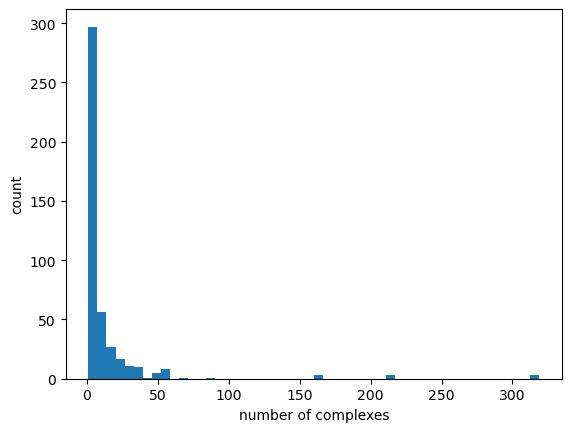

In [15]:
plt.hist(n_complexes_plot,bins=50)
plt.savefig('complex_distribution.png')
plt.ylabel('count')
plt.xlabel('number of complexes')

In [16]:
pdb_idxes = dict()
for i in ave_best_complexes:
    if ave_best_complexes[i] not in pdb_idxes.keys():
        pdb_idxes[ave_best_complexes[i]] = list()
    
    pdb_idxes[ave_best_complexes[i]].append(i)

In [17]:
len(ave_best_complexes)

8264

In [18]:
len(ave_best_complexes)

8264

filter None values

In [19]:
medians = {k:medians[k] for k in medians.keys() if medians[k]['distance'] is not None}
print('number of medians: {}'.format(len(medians)))
averages = {k:averages[k] for k in averages.keys() if averages[k]['distance'] is not None}
print('number of averages: {}'.format(len(averages)))

number_pdbs = list()
for i in averages.keys(): number_pdbs.append(averages[i]['pdb'])
len(set(number_pdbs))

number of medians: 6592
number of averages: 6592


394

# Show results

In [22]:
results_medians = da.get_prediction_scores(peptides, medians, cut=cut_medians)
results_averages = da.get_prediction_scores(peptides, averages, cut=cut_averages)
results_averages 

{'peptide': ['NEIAEDSEQFDK',
  'HSEFVAYPIQLLVT',
  'ELISNASDALDKIRYQ',
  'ALKDILGDQVEKVVVS',
  'HSEFVAYPIQLLVTK',
  'ALSDPKQLETEPDLFIR',
  'ALKDILGDQVEK',
  'RHSEFVAYPIQLL',
  'ALLTSGFSLEEPTSFASR',
  'AGETFEFQ',
  'HSEFVAYPIQLL',
  'LKDILGDQVEK',
  'SEFVAYPIQLLVTK',
  'KDILGDQVEK',
  'FYSAFAK',
  'DILGDQVEK',
  'ITPKPEEK',
  'SGSTEETTANTGTIGK',
  'STEETTANTGTIGK',
  'HVIQIPLNKPLLTEELAK',
  'EQFPLFAIHDMTEDLK',
  'DADAELADEEDAIHDEL',
  'SLDSLFDFIKEN',
  'AELADEEDAIHDEL',
  'SLDSLFDFIKENGHFDVDGK',
  'EQFPLFAIHD',
  'ADEEDAIHDEL',
  'YGLPQLSEEAFDELSDK',
  'SESVVYQGS',
  'HAGNLNMK',
  'KADIADAD',
  'YYAPWCGHCKR',
  'KLDHTENDVRGVVIEGYPTIVLYPGGK',
  'SLDSLFDFIK',
  'AFDELSDKIVLESK',
  'GYPTIVLYPGGK',
  'IYLPSAMDEPVVYNGK',
  'DSLFDFIK',
  'NMAPEYVKA',
  'YYAPWCGHCK',
  'ADIADADVFEK',
  'DFLKGDASPIVK',
  'SESVVYQGSR',
  'NRGLMNFVSIDAR',
  'NHDEIVNDPKKDVLVL',
  'QSQPAVAVVA',
  'AMDEPVVYNGK',
  'HFNDYDFVSA',
  'NHDEIVNDPKK',
  'RSLDSLFDFIKENGHFDVDGK',
  'VKDFLKGDASPIVK',
  'RSLDSLFDFIK',
  'NMAPE

In [26]:
results_averages_df = pd.DataFrame(results_averages)
results_averages_df.to_csv("./Output/Average_distance_random.csv", index = False)

In [142]:
print('Medians:')
da.compute_scores(results_medians)
da.show_data_balance(results_medians)
print('\nAverages:')
da.compute_scores(results_averages)
da.show_data_balance(results_averages)

Medians:
   *AUC ROC 0.5316160261684901 
   *AUC PR 0.2034728559493661
1254 positives
5338 negatives

Averages:
   *AUC ROC 0.6273005952025955 
   *AUC PR 0.030534749135001385
143 positives
6449 negatives


### print results for plots

Print AUC curve averages

In [144]:
AUC_curve = dict()

for i in range(len(results_averages['labels'])):
    AUC_curve[i] = dict()
    AUC_curve[i]['truth']=results_averages['labels'][i]
    AUC_curve[i]['prediction']=results_averages['q'][i]
    
filename = './Output/AUC_curve_averages_random10_cut_03.csv'
with open(filename, "w") as infile:
    writer = csv.DictWriter(infile, fieldnames=AUC_curve[0].keys())
    writer.writeheader()
    for i in AUC_curve.keys():
        writer.writerow(AUC_curve[i])

In [145]:
results_averages = pd.DataFrame.from_dict(results_averages)
print(len(set(results_averages.protein)))
results_averages.to_csv("Data_mapped_random_complexes_cut_03.csv", sep=',')

443


# Energy split

In [39]:
pisa_path = os.path.join(data_path, 'pisa')
pisa = ps.build_pisa_dict(pisa_path)

storing 1ygp.pisa, 0 of 2944
storing 5l67.pisa, 1 of 2944
storing 1ccp.pisa, 2 of 2944
storing 5ltt.pisa, 3 of 2944
storing 1nt9.pisa, 4 of 2944
storing 1cof.pisa, 5 of 2944
storing 1zwh.pisa, 6 of 2944
storing 1pu9.pisa, 7 of 2944
storing 4qwi.pisa, 8 of 2944
storing 1g6y.pisa, 9 of 2944
storing 3g5t.pisa, 10 of 2944
storing 2vw5.pisa, 11 of 2944
storing 1iou.pisa, 12 of 2944
storing 2ggp.pisa, 13 of 2944
storing 5d0s.pisa, 14 of 2944
storing 1ebe.pisa, 15 of 2944
storing 1csx.pisa, 16 of 2944
storing 2rpw.pisa, 17 of 2944
storing 3jro.pisa, 18 of 2944
storing 3sja.pisa, 19 of 2944
storing 7o73.pisa, 20 of 2944
storing 5a1v.pisa, 21 of 2944
storing 2xbu.pisa, 22 of 2944
storing 3zdm.pisa, 23 of 2944
storing 6ucu.pisa, 24 of 2944
storing 4ffb.pisa, 25 of 2944
storing 4ph7.pisa, 26 of 2944
storing 1k0a.pisa, 27 of 2944
storing 6opc.pisa, 28 of 2944
storing 1tkb.pisa, 29 of 2944
storing 6gd6.pisa, 30 of 2944
storing 6qsz.pisa, 31 of 2944
storing 5uek.pisa, 32 of 2944
storing 2cyp.pisa, 3

storing 3k7a.pisa, 269 of 2944
storing 3pgm.pisa, 270 of 2944
storing 1m94.pisa, 271 of 2944
storing 7o6b.pisa, 272 of 2944
storing 1rb7.pisa, 273 of 2944
storing 2aky.pisa, 274 of 2944
storing 6a3e.pisa, 275 of 2944
storing 5lg4.pisa, 276 of 2944
storing 6fvt.pisa, 277 of 2944
storing 4eu2.pisa, 278 of 2944
storing 2lnz.pisa, 279 of 2944
storing 7kar.pisa, 280 of 2944
storing 7tjx.pisa, 281 of 2944
storing 6qbm.pisa, 282 of 2944
storing 5nzv.pisa, 283 of 2944
storing 6uy1.pisa, 284 of 2944
storing 6b8h.pisa, 285 of 2944
storing 6p4x.pisa, 286 of 2944
storing 6hvu.pisa, 287 of 2944
storing 6lsu.pisa, 288 of 2944
storing 6omb.pisa, 289 of 2944
storing 7p47.pisa, 290 of 2944
storing 4y9y.pisa, 291 of 2944
storing 4a78.pisa, 292 of 2944
storing 6gyl.pisa, 293 of 2944
storing 1cig.pisa, 294 of 2944
storing 1i50.pisa, 295 of 2944
storing 6ql9.pisa, 296 of 2944
storing 6fsf.pisa, 297 of 2944
storing 2bre.pisa, 298 of 2944
storing 7tms.pisa, 299 of 2944
storing 1hqo.pisa, 300 of 2944
storing 

storing 4a3v.pisa, 538 of 2944
storing 2my2.pisa, 539 of 2944
storing 7m3p.pisa, 540 of 2944
storing 5z3g.pisa, 541 of 2944
storing 2qlt.pisa, 542 of 2944
storing 1aeq.pisa, 543 of 2944
storing 2p8x.pisa, 544 of 2944
storing 1csu.pisa, 545 of 2944
storing 4asw.pisa, 546 of 2944
storing 2vwc.pisa, 547 of 2944
storing 1ebh.pisa, 548 of 2944
storing 6uq2.pisa, 549 of 2944
storing 5fd9.pisa, 550 of 2944
storing 5l6a.pisa, 551 of 2944
storing 7v3u.pisa, 552 of 2944
storing 1bk5.pisa, 553 of 2944
storing 2iwx.pisa, 554 of 2944
storing 3how.pisa, 555 of 2944
storing 4m75.pisa, 556 of 2944
storing 6kw5.pisa, 557 of 2944
storing 1ypr.pisa, 558 of 2944
storing 4y8r.pisa, 559 of 2944
storing 3whk.pisa, 560 of 2944
storing 1twh.pisa, 561 of 2944
storing 2ycc.pisa, 562 of 2944
storing 1ijf.pisa, 563 of 2944
storing 5ip9.pisa, 564 of 2944
storing 2h1e.pisa, 565 of 2944
storing 2gb8.pisa, 566 of 2944
storing 5g5p.pisa, 567 of 2944
storing 1va7.pisa, 568 of 2944
storing 3m26.pisa, 569 of 2944
storing 

storing 5cza.pisa, 804 of 2944
storing 5l5y.pisa, 805 of 2944
storing 5wyk.pisa, 806 of 2944
storing 6g04.pisa, 807 of 2944
storing 3pgk.pisa, 808 of 2944
storing 3jck.pisa, 809 of 2944
storing 4qxj.pisa, 810 of 2944
storing 3uha.pisa, 811 of 2944
storing 6rgi.pisa, 812 of 2944
storing 7aqo.pisa, 813 of 2944
storing 4v1m.pisa, 814 of 2944
storing 7kat.pisa, 815 of 2944
storing 6f41.pisa, 816 of 2944
storing 6a3c.pisa, 817 of 2944
storing 5lyn.pisa, 818 of 2944
storing 2ogh.pisa, 819 of 2944
storing 3owt.pisa, 820 of 2944
storing 4kef.pisa, 821 of 2944
storing 4zux.pisa, 822 of 2944
storing 1tve.pisa, 823 of 2944
storing 6qld.pisa, 824 of 2944
storing 6hvs.pisa, 825 of 2944
storing 6xlg.pisa, 826 of 2944
storing 1n2d.pisa, 827 of 2944
storing 3oee.pisa, 828 of 2944
storing 6g90.pisa, 829 of 2944
storing 2brc.pisa, 830 of 2944
storing 7clv.pisa, 831 of 2944
storing 7kdf.pisa, 832 of 2944
storing 1ox4.pisa, 833 of 2944
storing 3plv.pisa, 834 of 2944
storing 1r53.pisa, 835 of 2944
storing 

storing 3a37.pisa, 1078 of 2944
storing 6i1d.pisa, 1079 of 2944
storing 3k1f.pisa, 1080 of 2944
storing 2rgr.pisa, 1081 of 2944
storing 7ca1.pisa, 1082 of 2944
storing 1a0a.pisa, 1083 of 2944
storing 1ifw.pisa, 1084 of 2944
storing 5uwi.pisa, 1085 of 2944
storing 5z8q.pisa, 1086 of 2944
storing 4kdl.pisa, 1087 of 2944
storing 5ajd.pisa, 1088 of 2944
storing 4y6z.pisa, 1089 of 2944
storing 1krj.pisa, 1090 of 2944
storing 3whl.pisa, 1091 of 2944
storing 2f6h.pisa, 1092 of 2944
storing 4y8u.pisa, 1093 of 2944
storing 1kb9.pisa, 1094 of 2944
storing 7ca0.pisa, 1095 of 2944
storing 1kl7.pisa, 1096 of 2944
storing 7kue.pisa, 1097 of 2944
storing 5uwh.pisa, 1098 of 2944
storing 1fi4.pisa, 1099 of 2944
storing 4y8t.pisa, 1100 of 2944
storing 2aqa.pisa, 1101 of 2944
storing 2cge.pisa, 1102 of 2944
storing 6fnu.pisa, 1103 of 2944
storing 1jvn.pisa, 1104 of 2944
storing 6kw3.pisa, 1105 of 2944
storing 5lai.pisa, 1106 of 2944
storing 3s1r.pisa, 1107 of 2944
storing 2r7z.pisa, 1108 of 2944
storing 

storing 2bwe.pisa, 1336 of 2944
storing 7fdc.pisa, 1337 of 2944
storing 5apo.pisa, 1338 of 2944
storing 5vsu.pisa, 1339 of 2944
storing 7ohv.pisa, 1340 of 2944
storing 3onl.pisa, 1341 of 2944
storing 1eo0.pisa, 1342 of 2944
storing 5hpl.pisa, 1343 of 2944
storing 7o4i.pisa, 1344 of 2944
storing 6qg6.pisa, 1345 of 2944
storing 4no1.pisa, 1346 of 2944
storing 5an3.pisa, 1347 of 2944
storing 4hb2.pisa, 1348 of 2944
storing 1k83.pisa, 1349 of 2944
storing 3gtm.pisa, 1350 of 2944
storing 6kmb.pisa, 1351 of 2944
storing 1zhw.pisa, 1352 of 2944
storing 1cpy.pisa, 1353 of 2944
storing 5c3e.pisa, 1354 of 2944
storing 3tkn.pisa, 1355 of 2944
storing 5kes.pisa, 1356 of 2944
storing 7tmt.pisa, 1357 of 2944
storing 2e7s.pisa, 1358 of 2944
storing 3rf6.pisa, 1359 of 2944
storing 6gyk.pisa, 1360 of 2944
storing 1ox5.pisa, 1361 of 2944
storing 6s8y.pisa, 1362 of 2944
storing 6mip.pisa, 1363 of 2944
storing 1r52.pisa, 1364 of 2944
storing 6ug1.pisa, 1365 of 2944
storing 4m6b.pisa, 1366 of 2944
storing 

storing 1dsg.pisa, 1594 of 2944
storing 2ksq.pisa, 1595 of 2944
storing 1yp5.pisa, 1596 of 2944
storing 5g5l.pisa, 1597 of 2944
storing 1ct5.pisa, 1598 of 2944
storing 4pvc.pisa, 1599 of 2944
storing 7aul.pisa, 1600 of 2944
storing 7k7g.pisa, 1601 of 2944
storing 6cqm.pisa, 1602 of 2944
storing 2ml8.pisa, 1603 of 2944
storing 5uwr.pisa, 1604 of 2944
storing 4ocn.pisa, 1605 of 2944
storing 1fuk.pisa, 1606 of 2944
storing 4y6a.pisa, 1607 of 2944
storing 2xgz.pisa, 1608 of 2944
storing 5w3f.pisa, 1609 of 2944
storing 1tk1.pisa, 1610 of 2944
storing 5cn1.pisa, 1611 of 2944
storing 4y8n.pisa, 1612 of 2944
storing 4geq.pisa, 1613 of 2944
storing 5d7e.pisa, 1614 of 2944
storing 6hwb.pisa, 1615 of 2944
storing 1zuy.pisa, 1616 of 2944
storing 4c92.pisa, 1617 of 2944
storing 2lox.pisa, 1618 of 2944
storing 3zj1.pisa, 1619 of 2944
storing 2fql.pisa, 1620 of 2944
storing 2rnx.pisa, 1621 of 2944
storing 4qux.pisa, 1622 of 2944
storing 4l6p.pisa, 1623 of 2944
storing 7tic.pisa, 1624 of 2944
storing 

storing 1i6h.pisa, 1852 of 2944
storing 6n8t.pisa, 1853 of 2944
storing 6huv.pisa, 1854 of 2944
storing 7tmo.pisa, 1855 of 2944
storing 5zi3.pisa, 1856 of 2944
storing 1ofr.pisa, 1857 of 2944
storing 4yg8.pisa, 1858 of 2944
storing 6fsz.pisa, 1859 of 2944
storing 2jd5.pisa, 1860 of 2944
storing 6gyp.pisa, 1861 of 2944
storing 5zwo.pisa, 1862 of 2944
storing 2h0r.pisa, 1863 of 2944
storing 4c31.pisa, 1864 of 2944
storing 2oe0.pisa, 1865 of 2944
storing 3fks.pisa, 1866 of 2944
storing 7n9f.pisa, 1867 of 2944
storing 5hwi.pisa, 1868 of 2944
storing 6zh3.pisa, 1869 of 2944
storing 4g4s.pisa, 1870 of 2944
storing 4c3j.pisa, 1871 of 2944
storing 7mei.pisa, 1872 of 2944
storing 6qbq.pisa, 1873 of 2944
storing 2eup.pisa, 1874 of 2944
storing 6o3x.pisa, 1875 of 2944
storing 1m0w.pisa, 1876 of 2944
storing 6htp.pisa, 1877 of 2944
storing 1ka0.pisa, 1878 of 2944
storing 6gen.pisa, 1879 of 2944
storing 7d5c.pisa, 1880 of 2944
storing 1stq.pisa, 1881 of 2944
storing 7kcb.pisa, 1882 of 2944
storing 

storing 4b2q.pisa, 2110 of 2944
storing 5mq0.pisa, 2111 of 2944
storing 5fg7.pisa, 2112 of 2944
storing 3j16.pisa, 2113 of 2944
storing 3zia.pisa, 2114 of 2944
storing 3gto.pisa, 2115 of 2944
storing 1lms.pisa, 2116 of 2944
storing 4hb0.pisa, 2117 of 2944
storing 6zqh.pisa, 2118 of 2944
storing 1p84.pisa, 2119 of 2944
storing 5l5o.pisa, 2120 of 2944
storing 3l0x.pisa, 2121 of 2944
storing 1nyn.pisa, 2122 of 2944
storing 1zzd.pisa, 2123 of 2944
storing 7o4k.pisa, 2124 of 2944
storing 5gap.pisa, 2125 of 2944
storing 1ukz.pisa, 2126 of 2944
storing 5k2f.pisa, 2127 of 2944
storing 3bit.pisa, 2128 of 2944
storing 7oht.pisa, 2129 of 2944
storing 5l54.pisa, 2130 of 2944
storing 7kmt.pisa, 2131 of 2944
storing 7fda.pisa, 2132 of 2944
storing 6xi8.pisa, 2133 of 2944
storing 4fk5.pisa, 2134 of 2944
storing 5w51.pisa, 2135 of 2944
storing 1g7c.pisa, 2136 of 2944
storing 4asf.pisa, 2137 of 2944
storing 3cpi.pisa, 2138 of 2944
storing 7p03.pisa, 2139 of 2944
storing 7tk5.pisa, 2140 of 2944
storing 

storing 1bgw.pisa, 2367 of 2944
storing 5mps.pisa, 2368 of 2944
storing 1s73.pisa, 2369 of 2944
storing 4gpt.pisa, 2370 of 2944
storing 5l65.pisa, 2371 of 2944
storing 5j9t.pisa, 2372 of 2944
storing 4g50.pisa, 2373 of 2944
storing 4m7a.pisa, 2374 of 2944
storing 2ftx.pisa, 2375 of 2944
storing 3m29.pisa, 2376 of 2944
storing 6enl.pisa, 2377 of 2944
storing 6lp3.pisa, 2378 of 2944
storing 7ked.pisa, 2379 of 2944
storing 2ljl.pisa, 2380 of 2944
storing 1ynz.pisa, 2381 of 2944
storing 6hko.pisa, 2382 of 2944
storing 6l0i.pisa, 2383 of 2944
storing 4xnh.pisa, 2384 of 2944
storing 2l41.pisa, 2385 of 2944
storing 5dki.pisa, 2386 of 2944
storing 3m2b.pisa, 2387 of 2944
storing 6rqh.pisa, 2388 of 2944
storing 1twg.pisa, 2389 of 2944
storing 6n8j.pisa, 2390 of 2944
storing 6ae8.pisa, 2391 of 2944
storing 2ik2.pisa, 2392 of 2944
storing 2jky.pisa, 2393 of 2944
storing 6vzg.pisa, 2394 of 2944
storing 5vko.pisa, 2395 of 2944
storing 2ckz.pisa, 2396 of 2944
storing 3hox.pisa, 2397 of 2944
storing 

storing 1qgx.pisa, 2639 of 2944
storing 1ef0.pisa, 2640 of 2944
storing 1sse.pisa, 2641 of 2944
storing 6zdt.pisa, 2642 of 2944
storing 6pto.pisa, 2643 of 2944
storing 3fky.pisa, 2644 of 2944
storing 6oa9.pisa, 2645 of 2944
storing 1yag.pisa, 2646 of 2944
storing 6t15.pisa, 2647 of 2944
storing 5d80.pisa, 2648 of 2944
storing 4kg4.pisa, 2649 of 2944
storing 2cvv.pisa, 2650 of 2944
storing 3jc5.pisa, 2651 of 2944
storing 5voz.pisa, 2652 of 2944
storing 7riw.pisa, 2653 of 2944
storing 4xv8.pisa, 2654 of 2944
storing 2mzt.pisa, 2655 of 2944
storing 5w5y.pisa, 2656 of 2944
storing 3d4m.pisa, 2657 of 2944
storing 2jac.pisa, 2658 of 2944
storing 5c4j.pisa, 2659 of 2944
storing 6fvw.pisa, 2660 of 2944
storing 3by4.pisa, 2661 of 2944
storing 6f44.pisa, 2662 of 2944
storing 7kaq.pisa, 2663 of 2944
storing 2ja8.pisa, 2664 of 2944
storing 1yjo.pisa, 2665 of 2944
storing 3pew.pisa, 2666 of 2944
storing 1b4l.pisa, 2667 of 2944
storing 1fq6.pisa, 2668 of 2944
storing 1ah8.pisa, 2669 of 2944
storing 

storing 4qz4.pisa, 2901 of 2944
storing 7dbg.pisa, 2902 of 2944
storing 4bbr.pisa, 2903 of 2944
storing 4gmx.pisa, 2904 of 2944
storing 7luv.pisa, 2905 of 2944
storing 6gsm.pisa, 2906 of 2944
storing 2mkc.pisa, 2907 of 2944
storing 5jgf.pisa, 2908 of 2944
storing 7bbt.pisa, 2909 of 2944
storing 4a3m.pisa, 2910 of 2944
storing 7tkd.pisa, 2911 of 2944
storing 4ya3.pisa, 2912 of 2944
storing 7dsi.pisa, 2913 of 2944
storing 3vyc.pisa, 2914 of 2944
storing 4ce3.pisa, 2915 of 2944
storing 6blo.pisa, 2916 of 2944
storing 6ixq.pisa, 2917 of 2944
storing 6h08.pisa, 2918 of 2944
storing 1aej.pisa, 2919 of 2944
storing 5c77.pisa, 2920 of 2944
storing 4cgq.pisa, 2921 of 2944
storing 2eqb.pisa, 2922 of 2944
storing 6eyw.pisa, 2923 of 2944
storing 6c6l.pisa, 2924 of 2944
storing 7aur.pisa, 2925 of 2944
storing 6m6x.pisa, 2926 of 2944
storing 7kkf.pisa, 2927 of 2944
storing 3tz3.pisa, 2928 of 2944
storing 2pm6.pisa, 2929 of 2944
storing 6jsi.pisa, 2930 of 2944
storing 2f66.pisa, 2931 of 2944
storing 

In [26]:
missing_pisa = {k:pisa[k] for k in pisa.keys() if len(pisa[k].keys())==0}
pisa = {k:pisa[k] for k in pisa.keys() if len(pisa[k].keys())>0}
print(len(missing_pisa), len(pisa))

0 1518


In [38]:
pisa['3zdm']

{'1': {'diss_energy': '-0',
  'asa': '4978.5635829',
  'bsa': '0',
  'entropy': '0',
  'diss_area': '0',
  'int_energy': '0'},
 '2': {'diss_energy': '-0',
  'asa': '4978.5635829',
  'bsa': '0',
  'entropy': '0',
  'diss_area': '0',
  'int_energy': '0'},
 '3': {'diss_energy': '-0',
  'asa': '4978.5635829',
  'bsa': '0',
  'entropy': '0',
  'diss_area': '0',
  'int_energy': '0'},
 '4': {'diss_energy': '-0.57109610941',
  'asa': '10956.981848',
  'bsa': '2617.242189',
  'entropy': '10.46949234',
  'diss_area': '613.11570572',
  'int_energy': '-24.023181501'},
 '5': {'diss_energy': '-0',
  'asa': '4978.5635829',
  'bsa': '0',
  'entropy': '0',
  'diss_area': '0',
  'int_energy': '0'}}

In [377]:
energy_cut = 0
#pisa_info = ps.get_higest_bsa_energies(pisa, cut=energy_cut)
low_energy_cut = 10
high_energy_cut = 10
pisa_info = ps.split_bsa_energies(pisa, low_energy_cut, high_energy_cut)

In [378]:
len(pisa_info['low_energy_pdb'])

531

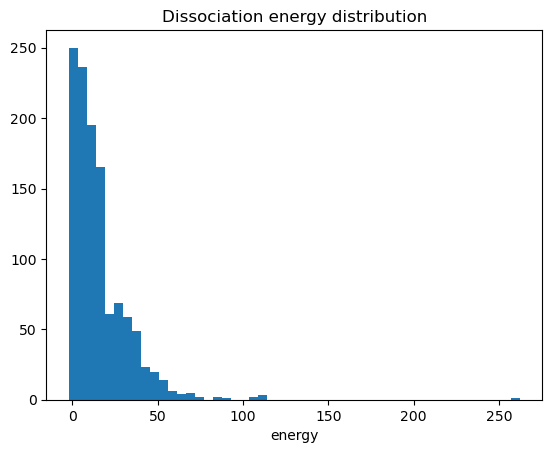

In [379]:
plt.title('Dissociation energy distribution')
plt.xlabel('energy')
_ = plt.hist(pisa_info['energies'], bins=50)

In [380]:
pisa_medians = ps.pisa_split(medians, pisa_info)
pisa_averages = ps.pisa_split(averages, pisa_info)

In [381]:
results_medians_low = da.get_prediction_scores(peptides, pisa_medians['low_energies'], cut=cut_medians)
results_medians_middle = da.get_prediction_scores(peptides, pisa_medians['middle_energies'], cut=cut_medians)
results_medians_high = da.get_prediction_scores(peptides, pisa_medians['high_energies'], cut=cut_medians)

results_averages_low = da.get_prediction_scores(peptides, pisa_averages['low_energies'], cut=cut_averages)
results_averages_middle = da.get_prediction_scores(peptides, pisa_averages['middle_energies'], cut=cut_averages)
results_averages_high = da.get_prediction_scores(peptides, pisa_averages['high_energies'], cut=cut_averages)

In [382]:
print('\nAverages: \n Low energy:')
da.compute_scores(results_averages_low)
da.show_data_balance(results_averages_low)
print('Middle energy:')
#da.compute_scores(results_averages_middle)
#da.show_data_balance(results_averages_middle)
print(' High energy:')
da.compute_scores(results_averages_high)
da.show_data_balance(results_averages_high)


Averages: 
 Low energy:
   *AUC ROC 0.5555242839352428 
   *AUC PR 0.20562127693627447
292 positives
1375 negatives
Middle energy:
 High energy:
   *AUC ROC 0.5353029684095861 
   *AUC PR 0.207051790778568
425 positives
1728 negatives


In [368]:
print('Medians: \n Low energy:')
da.compute_scores(results_medians_low)
da.show_data_balance(results_medians_low)
print(' Middle energy:')
da.compute_scores(results_medians_middle)
da.show_data_balance(results_medians_middle)
print(' High energy:')
da.compute_scores(results_medians_high)
da.show_data_balance(results_medians_high)

Medians: 
 Low energy:
   *AUC ROC 0.5758334851521225 
   *AUC PR 0.21652847575618692
88 positives
499 negatives
 Middle energy:
   *AUC ROC 0.5280568493013772 
   *AUC PR 0.19088839918593534
570 positives
2633 negatives
 High energy:
   *AUC ROC 0.43939393939393934 
   *AUC PR 0.1489566309243306
9 positives
44 negatives
